**Linear Flow in Gaussian data**

In this code, we are going to show how train a very simple linear flow, used to transform Gaussian data. If you have any questions, you can contact the instructor.

The first thing we need to do is to import the necessary libraries. We will use numpy, matplotlib, torch and tqdm. We will also use the magic command `%matplotlib inline` to show the plots in the notebook. Note that we also seed the code for reproducibility.

In [74]:
# Code adapted from https://binpord.github.io/2021/11/10/normalizing_flows.html
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import torch
import torch.nn as nn

# Seed everything for reproducibility
rng = np.random.default_rng(1234)
_ = torch.manual_seed(1234)

The first thig we do is to generate a target density. We will use a bidimensional Gaussian distribution with mean $\mu = (5, 7)$ and covariance matrix $\Sigma = \begin{bmatrix} 2 & 0.7 \\ 0.7 & 1 \end{bmatrix}$. Note that we only have access to samples from this distribution in order to train our model later.

In [75]:
# Generate the target density
batch_size = 100  # Batch size
val_size = int(0.2 * batch_size)  # Samples used to validate

def target_base_sample(batch_size):  # Target distribution: note that we only have access to samples from this distribution!
    return rng.multivariate_normal(mean=np.array([5., 7.]), cov=np.array([[2., .7], [.7, 1.]]), size=batch_size)

As base distribution (i.e., the distribution we are going to transform), we use a bidimensional Gaussian distribution with mean $\mu = (0, 0)$ and covariance matrix $\Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$.

In [76]:
# Base distribution: Bidimensional Standard Gaussian
base_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Now, create the torch model. It is a simple model, with a single layer. Note that we do not use any activation function, as we want to have a linear transformation.

Remember that the math behind this transformation is the following: if we denote the base distribution as $p_z(z)$ and the target distribution (which is unknown to us) as $p_x(x)$, then we want to find a transformation $f$ such that $p_x(x)$ can be evaluated using $p_z(f(x))$. According to the change of variables formula, we have that:

$p_x(x) = p_z(f(x)) \left| \det \left( \frac{\partial f}{\partial z} \right) \right|$

So we can compute the log-likelihood of the unknown target distribution as follows:

$\log p_x(x) = \log p_z(f(x)) + \log \left| \det \left( \frac{\partial f}{\partial z} \right) \right|$

where we note that we only need to know the base distribution $p_z(z)$ and the transformation $f$ to compute the log-likelihood of the (unkwnown) target distribution $p_x(x)$.

To clarify, the transformation $f$ is a function that takes a sample from the target distribution $x$ and transforms it into a sample from the base distribution $z$. The inverse transformation $f^{-1}$ takes a sample from the base distribution $z$ and transforms it into a sample from the target distribution $x$.

Let us particularize for the case of a linear transformation:
* The transformation is $z = f(x) = W x + b$, where $W$ is a matrix and $b$ is a vector. For implementation purposes (in Torch, the first dimension is the batch dimension), we will work with the transposed version of the transform, which is $f(x)^T = x^T W^T + b^T$. Note that this transformation takes samples from the target distribution $x$ and transforms them into samples from the base distribution $z$.
* We are interested also in the inverse transformation $x = f^{-1}(z) = (z - b) W^{-1}$. Note that this transformation takes samples from the base distribution $z$ and transforms them into samples from the target distribution $x$. If we consider the transposed version of the inverse transformation, we have $x^T = f^{-1}(z)^T = (z - b)^T W^{-T}$.
* The Jacobian of the transformation is $\frac{\partial f}{\partial z} = W$. Since the Jacobian is symmetric, we have $W=W^T$.

With all this information, we can implement a simple Linear Flow as follows, where we take advantage of knowing the Jacobian of the transformation. Note that `torch.slogdet` returns the sign and the log of the determinant of a matrix, and it is used to compute the log of the determinant of the Jacobian.

In [77]:
class LinearFlow(nn.Module):
    def __init__(self, size=2):
        super().__init__()
        # Initialize parameters randomly.
        self.W = nn.Parameter(torch.randn(size, size)) # Note: this is W^T in the notation above
        self.b = nn.Parameter(torch.randn(1, size))  # Note: this is b^T in the notation above

    def forward(self, target):
        # Forward: from target to base distribution
        base = target @ self.W + self.b
        return base, torch.slogdet(self.W).logabsdet

    def inverse(self, base):
        # Inverse: from base distribution to target
        target = (base - self.b) @ torch.inverse(self.W)
        return target

model = LinearFlow()

Before doing any training, we will show the results of the model without training. Note that the model is initialized with a random transformation, so the results are not good (as expected).

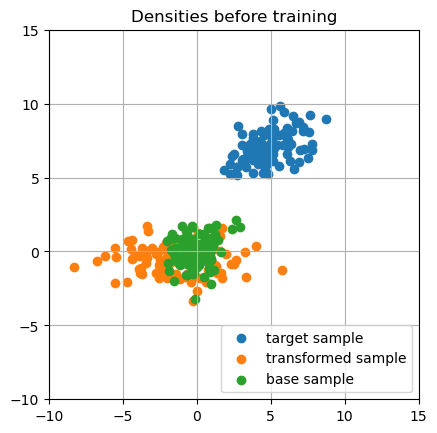

In [78]:
target_sample = target_base_sample(batch_size)
base_sample = base_distribution.sample([batch_size]).detach().cpu().numpy()
init_sample = model.inverse(base_distribution.sample([batch_size])).detach().cpu().numpy() # Plot this to see the initial inverse transformation (from base to target)

# Plot results before training
plt.scatter(target_sample[:, 0], target_sample[:, 1], label='target sample')
plt.scatter(init_sample[:, 0], init_sample[:, 1], label='transformed sample')
plt.scatter(base_sample[:, 0], base_sample[:, 1], label='base sample')
plt.xlim(-10, 15)
plt.ylim(-10, 15)
plt.gca().set_aspect('equal')
plt.legend(loc='lower right')
plt.title('Densities before training')
plt.grid()
plt.show()

We are now ready to train the model. Remember that the train loss is the negative log-likelihood of the target $p_x(x)$ (as we want to maximize this log-likelihood). According to the expressions we showed above, we have that:

$\log p_x(x) = \log p_z(f(x)) + \log \left| \det \left( \frac{\partial f}{\partial z} \right) \right| = \log p_z(f(x)) + \log \left| \det \left( W^T \right) \right|$

The training code next is a direct implementation of this expression. Note that we use the Adam optimizer, and we use the validation set to monitor the training process. We also show the results of the model after training.

100%|██████████| 10000/10000 [00:09<00:00, 1105.41it/s]


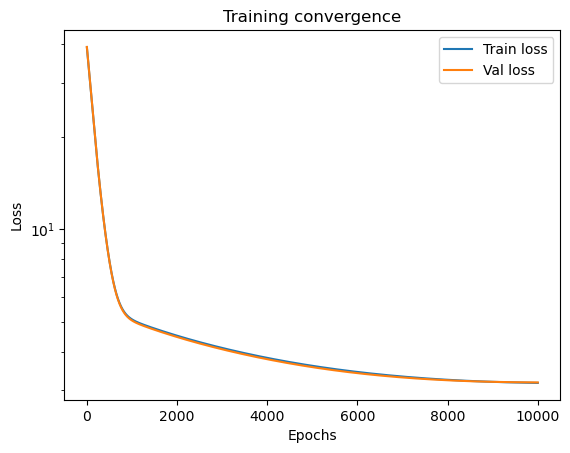

In [79]:
n_epochs = 10000
optimizer = torch.optim.Adam(model.parameters())

x_train = torch.from_numpy(target_sample[0: -val_size]).float()
x_val = torch.from_numpy(target_sample[val_size: ]).float()
transformed_samples = []

train_losses, val_losses = [], []

for i in tqdm(range(n_epochs)):
    # Train step
    base_sample, logabsdet = model(x_train)
    loss = base_distribution.log_prob(base_sample) + logabsdet
    loss = - torch.mean(loss)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation step
    with torch.no_grad():
        base_sample, logabsdet = model(x_val)
        loss = base_distribution.log_prob(base_sample) + logabsdet
        loss = - torch.mean(loss)

    val_losses.append(loss.item())

    if (i + 1) % 1000 == 0:
        transformed_samples.append((i + 1, model.inverse(base_distribution.sample([batch_size])).detach().cpu().numpy()))

# Show training results
plt.semilogy(train_losses, label='Train loss')
plt.semilogy(val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training convergence')
plt.legend(loc='best')
plt.show()

Finally, we are going to show the results of the model after training. Note that the model is able to transform the base distribution into a distribution that is very similar to the target distribution.

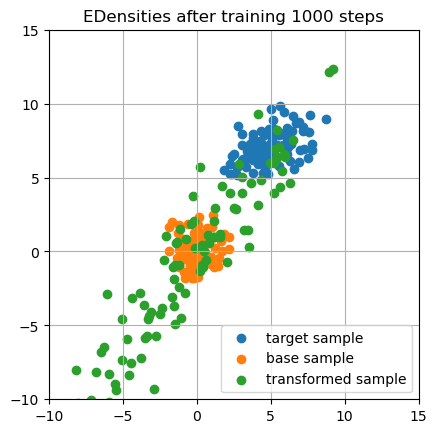

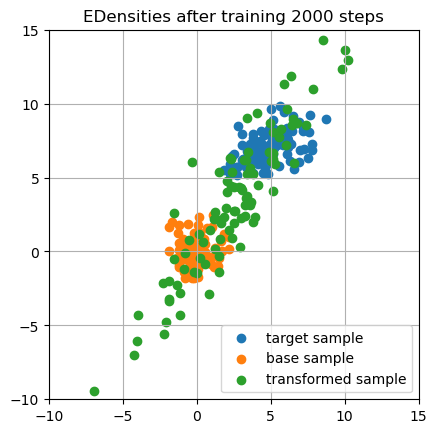

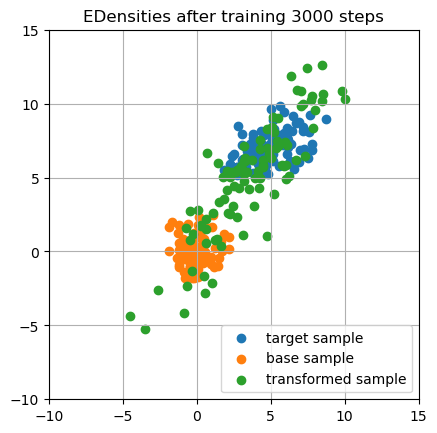

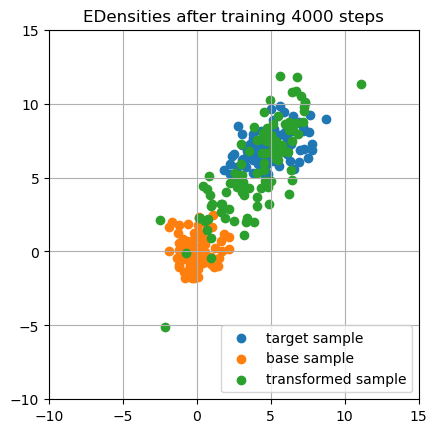

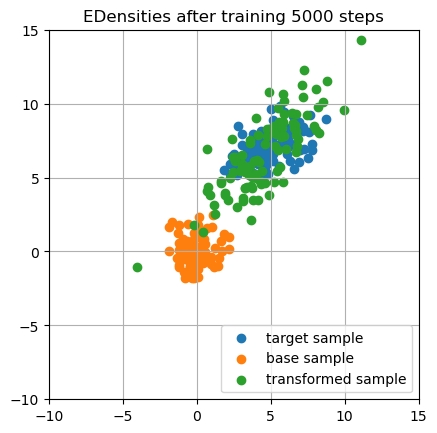

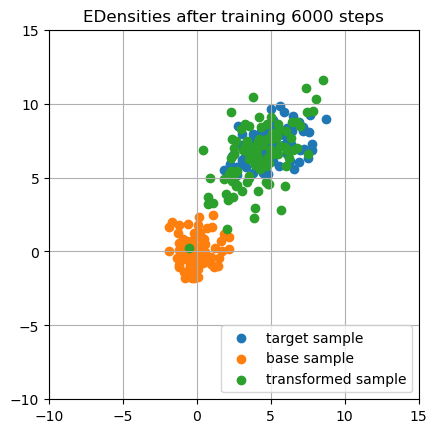

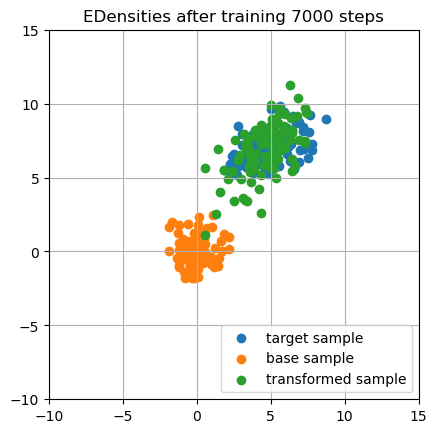

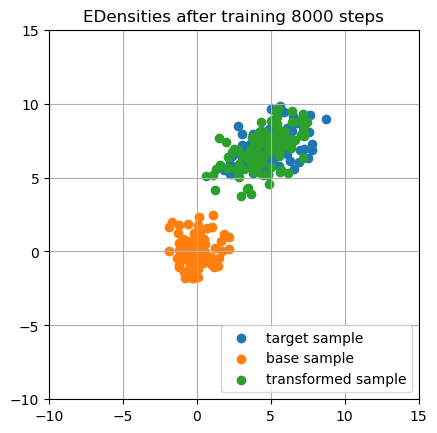

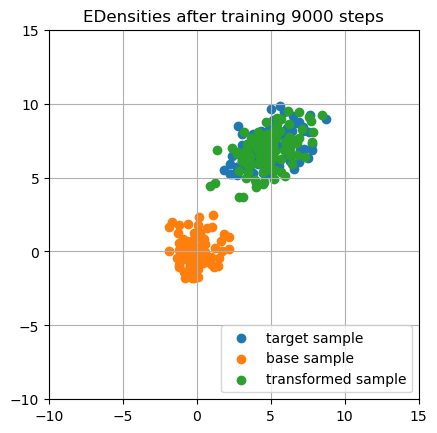

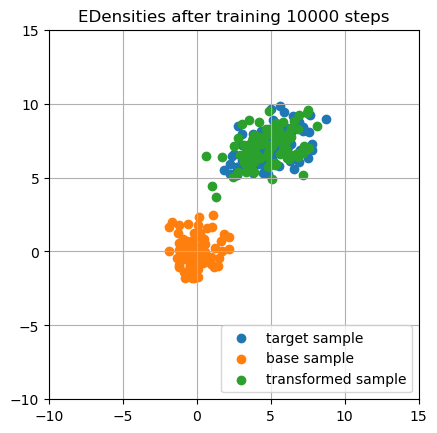

In [80]:
# Plot results after training
for data in transformed_samples:
  i, transformed_sample = data
  plt.scatter(target_sample[:, 0], target_sample[:, 1], label='target sample')
  plt.scatter(base_sample[:, 0], base_sample[:, 1], label='base sample')
  plt.scatter(transformed_sample[:, 0], transformed_sample[:, 1], label='transformed sample')
  plt.xlim(-10, 15)
  plt.ylim(-10, 15)
  plt.gca().set_aspect('equal')
  plt.legend(loc='lower right')
  plt.title('EDensities after training ' + str(i) + ' steps')
  plt.grid()
  plt.show()